Refer to the [Wikipedia article](https://en.wikipedia.org/wiki/Self-avoiding_walk) on self-avoiding walks for a good primer on the subject. [Bauerschmidt et al. (2012)](https://www.ihes.fr/~duminil/publi/saw_lecture_notes.pdf) give an extremely thorough description of known qualities of self-avoiding random walks and their connections to other areas of mathematics. Here are links to some other resources I found informative:
 - https://mathoverflow.net/questions/158811/wander-distance-of-self-avoiding-walk-that-backs-out-of-culs-de-sac
 - https://mathoverflow.net/questions/52813/self-avoiding-walk-enumerations
 - https://mathoverflow.net/questions/41543/how-to-characterize-a-self-avoiding-
 - https://mathoverflow.net/questions/54144/self-avoiding-walk-pair-correlation
 - https://mathoverflow.net/questions/23583/self-avoidance-time-of-random-walk
 - https://mathoverflow.net/questions/181340/square-filling-self-avoiding-walk
 
Some exhaustive results by numerical simulation are available here:
 - https://secure.math.ubc.ca/~slade/lacecounts/index.html
 - https://secure.math.ubc.ca/~slade/se_tables.pdf
 
Here are some other academic results on the topic:
 - https://secure.math.ubc.ca/~slade/se_tables.pdf
 - https://www.sciencedirect.com/science/article/abs/pii/0032386185900084?via%3Dihub
 - https://journals.aps.org/prb/abstract/10.1103/PhysRevB.31.2993
 - https://arxiv.org/abs/1408.6714
 
Other interesting simulations/related information:
 - https://mathoverflow.net/questions/88659/traversing-the-infinite-square-grid
 - https://mathoverflow.net/questions/306794/counting-hamiltonian-cycles-in-n-times-n-square-grid
 - https://iopscience.iop.org/article/10.1088/0305-4470/38/42/001
 - https://mathoverflow.net/questions/67192/exactly-simulating-a-random-walk-from-infinity

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import itertools
import random

In [666]:
dimensions = 2
D = dimensions
z = 10

start = [0, 0]
choices = []

for n in range(dimensions):
    for y in [-1, 1]:
        delta = np.zeros(dimensions).astype(np.int)
        delta[n] = y
        choices.append(delta)
choices = np.stack(choices)

print(choices)

[[-1  0]
 [ 1  0]
 [ 0 -1]
 [ 0  1]]


In [650]:
steps = []
@nb.njit
def valid_moves(g, m, q):
#     filtered = list(filter(lambda c: (0<=pos+c).all() and (pos+c<z).all() and grid[tuple(pos+c)] == 0, m))
    filtered = []
    for i in m:
#         print(pos, m)
        p = q+i
#         if (0<=p).all() and (p<z).all() and g[p[0], p[1]] == 0:
        if (0<=p).all():
            if (p<z).all():
                if g[p[0], p[1]] == 0:
#                     print(p, g[p[0], p[1]], (p<z).all(), z)
                    filtered.append(i)
    return filtered

In [667]:
@nb.jit(nopython=True)
def bound(x, a, b):
    if x >= b:
        x = b-1
    elif x < a:
        x = a
    return x

@nb.njit
def clip(x, a, b):
    for i in range(x.shape[0]):
        x[i] = bound(x[i], a, b)
    return x

In [690]:
@nb.njit#(parallel=True)
def simulate(backtrack=True):
    for x in range(1):
        pos = np.array([4,4])
#         grid = np.zeros([z] * D)
        grid = np.zeros((z, z), dtype=np.int64)
        lengths = []
        walks = []
        steps = []
        for t in range(z**2):
    #         print(0<pos+delta[0]<z)
    #         print(grid[tuple(pos+delta[0])])
            possible = valid_moves(grid, choices, pos)
#             print(possible)
            grid[pos[0], pos[1]] = t+(z**2//4)
            
            if len(possible) > 0:
#                 delta = random.choice(possible)
#                 delta = np.random.choice(possible)
#                 np.random.shuffle(possible)
                index = np.random.randint(0, len(possible))
                delta = possible[index]

#                 steps.append(delta)
                pos += delta
                steps.append(delta)
#                 pos = np.clip(pos, 0, z-1)
                
                pos = clip(pos, 0, z)
                
#                 grid[tuple(pos)] = 1
#                 print(pos[0])
            else:
                lengths.append(t)
#                 walks.append(grid)
                if backtrack:
                    pos -= delta
                    steps.pop()
                else:
                    break
#         else:
        walks.append(grid)
    return grid

(-0.5, 9.5, 9.5, -0.5)

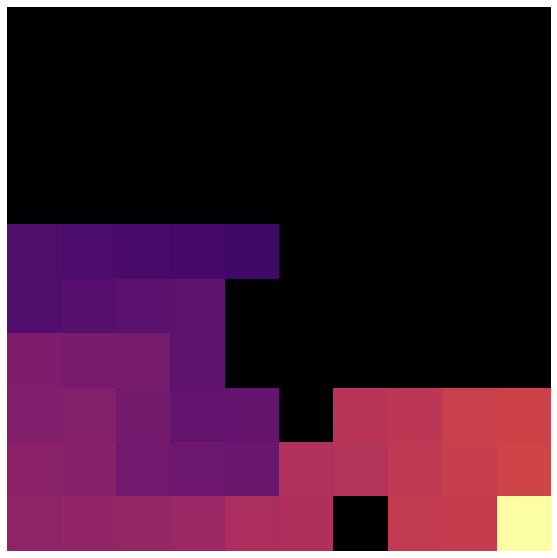

In [732]:
best = None
lengths = []
walks = []
for i in range(100):
    G = simulate(True)
#     if best:
#         print(best.max())
    lengths.append(G.max())
    walks.append(G)
    if best is None or G.max() > best.max():
        best = G

plt.figure(figsize=(10, 10))
plt.imshow(best, cmap='inferno')
plt.axis('off')
# decision trees? + parity
# random walks that close to a polygon
# (self-avoiding) random walks around obstructions
# add heuristics
# avoid and/or break at 
# add backtracking

(array([76., 60., 56., 64., 68., 57., 67., 75., 56., 40., 53., 46., 33.,
        31., 32., 35., 29., 22., 17.,  5.,  8.,  6., 10.,  1.,  1.,  0.,
         0.,  1.,  0., 51.]),
 array([ 30.        ,  33.13333333,  36.26666667,  39.4       ,
         42.53333333,  45.66666667,  48.8       ,  51.93333333,
         55.06666667,  58.2       ,  61.33333333,  64.46666667,
         67.6       ,  70.73333333,  73.86666667,  77.        ,
         80.13333333,  83.26666667,  86.4       ,  89.53333333,
         92.66666667,  95.8       ,  98.93333333, 102.06666667,
        105.2       , 108.33333333, 111.46666667, 114.6       ,
        117.73333333, 120.86666667, 124.        ]),
 <BarContainer object of 30 artists>)

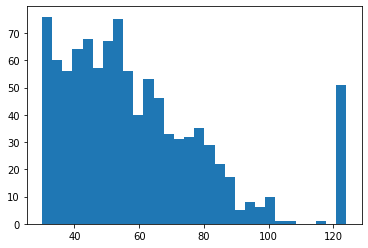

In [685]:
plt.hist(lengths, bins=30)

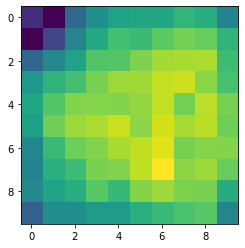

In [619]:
plt.imshow(np.average(np.stack(walks), axis=0))